In [27]:
#%matplotlib notebook

this notebook demonstrates and visualizes the EM algorithm on the simplest example: just one parameter and just one hidden variable.

In [28]:
import numpy as np
import matplotlib.pyplot as plt


we'll simulate the usual gaussian mixture model setup:
we have data generated by 2 bivariate normal clusters:

a red cluster centered at $cx_0, cy_0 = (1,0)$ and a blue cluster centered at $cx_1, cy_1 = (2,0)$. The standard deviation of both is $\sigma_0 = \sigma_1 = 1$, and the weight of the red cluster is $p=0.4$ (and of course the blue cluster has a weight of $1-0.4=0.6$).

we will call all of these parameters $\theta$.

we will simulate and plot $N=10$ samples

In [29]:
cx = [1, 2]
cy = [0, 0]
sig = [1, 1]
p = 0.4

N = 10

In [30]:
samples = []
for i in range(N):
    if np.random.uniform() < p:
        c = 0
    else:
        c = 1
    x, y = np.random.multivariate_normal(
        (cx[c], cy[c]), [[sig[c], 0], [0, sig[c]]])
    samples.append({"c": c, "x": x, "y": y})


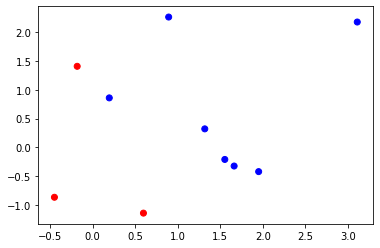

In [31]:
def color_key(c):
        if c == 0: 
            return 'r'
        elif c == 1:
            return 'b'
        else: 
            return 'gray'
        
def scatter_samples(samples):
    plt.scatter([t["x"] for t in samples], [t["y"] for t in samples],
               color = [color_key(t["c"]) for t in samples])
    plt.show()
scatter_samples(samples)

complete likelihood: when everything is observed (the location and color of every sample), how likely are the data we are seeing given the parameters? we'll define it using an indicator variable $I_{i,k}$ which is $1$ if sample $i$ is assigned to cluster $k$: 

(ignore the $d$ parameter, it's a spoiler for later...)

In [32]:
def I(i, k, d):
    s = samples[i]
    if s['c'] is not None:
        # observed sample, just an indicator variable
        return (1 if s['c'] == k else 0)
    else:
        # a hidden sample
        return (d if k == 0 else 1-d)


also we define $q_{i, k}=P(x_i, c_i=k | \theta) = \frac{p_k}{2\pi\sigma_k^2}exp(
-\frac{(x_i-cx_k)^2 + (y_i-cy_k)^2)}{2\sigma_k^2}) $

NOTE1: the actual function takes only $p$ and not the entire $\theta$ as it should because of a simplification - in this notebook we're leaving all the other parameters as constants.

NOTE2: for an observed sample $i$ from cluster k: $P(x_i, c_i=k'| \theta) = 0$ - i.e. a red sample can not be from the blue cluster and vice versa

In [33]:
def q(i, k, p):
    s = samples[i]
    if s['c'] is not None and s['c'] != k:
        return 0
    return (p if k==0 else 1-p) / (2*np.pi*sig[k]**2) * \
        np.exp(-((s['x'] - cx[k])**2 + (s['y'] - cy[k])**2) / (2 * sig[k]**2))

In [34]:
def mul(a, b):
    if a == 0:
        return 0
    else:
        return a * b

the complete (log) likelihood is a function of the parameters $\theta$ (in this notebook we'll simplify to only $p$) and it is just a log of the product of all those $q_{i,k}$, which is the sum of logs:

$f_{\bar x, \bar c}(\theta) = \sum_i^N I_{i,0}log(q_{i,0}) + I_{i,1}log(q_{i,1})$

(again, ignore the $d$ parameter for now)

In [35]:
def complete_likelihood_simple(p, d):
    return sum(
        [mul(I(i, 0, d), np.log(q(i, 0, p))) + 
         mul(I(i, 1, d), np.log(q(i, 1, p)))
             for i, s in enumerate(samples)])
    return l


now we'll compute the exact same thing in a fancy way. 

using tedious algebra (not shown on this notebook), we can cleanly separate the above formula to a linear combination of :
1. **sufficient statistics** - functions of the data, without parameters - we'll denote these as $n_i$
2. functions of the parameters - we'll denote these as $f_i$

this seems redundant now, but will be very useful later, when we won't see all data

In [36]:

def n1(k, d):
    return sum([1*I(i, k, d) for i, s in enumerate(samples)])
    
def n2(k, d):
    return sum([s['x']*I(i, k, d) for i, s in enumerate(samples)])

def n3(k, d):
    return sum([s['y']*I(i, k, d) for i, s in enumerate(samples)])

def n4(k, d):
    return sum([0.5*I(i, k, d)*(s['x']**2 + s['y']**2) for 
                i, s in enumerate(samples)])


In [37]:
def f1(k, p):
    return (np.log((p if k==0 else 1-p))-\
                          np.log(2*np.pi*sig[k]**2)-\
                          cx[k]**2/(2*sig[k]**2) - cy[k]**2/(2*sig[k]**2))
def f2(k, p):
    return cx[k]/(sig[k]**2)

def f3(k, p):
    return cy[k]/(sig[k]**2)

def f4(k, p):
    return (-1)/(sig[k]**2)


the complete (log) likelihood using sufficient statistics:

$f_{\bar x, \bar c}(\theta) = \sum_j n_j(\bar x, \bar c) f_j(\theta)$


In [38]:
def complete_likelihood_sufficient_statistics(p, d):
    l = 0
    for k in [0, 1]:
        l += n1(k, d)*f1(k, p)
        l += n2(k, d)*f2(k, p)
        l += n3(k, d)*f3(k, p)
        l += n4(k, d)*f4(k, p)
    return l


now we'll "prove" that our algebra was right:

In [39]:
complete_likelihood_simple(p, None), complete_likelihood_sufficient_statistics(p, None)

/Users/hadanny/ws/st_demand_prediction/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


(-37.29735970920802, -37.29735970920801)

And now for the challenge: we'll hide away the $p$ parameter and the cluster assignment of the last sample $c_{N-1}$ and see how well EM guesses them!

In [40]:
print(f"p={p}, C(N-1)={samples[N-1]['c']}")

p=0.4, C(N-1)=1


In [41]:
p = None
samples[N-1]["c"] = None

the sample with the hidden cluster assignment is marked in gray: 

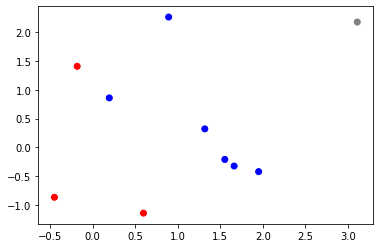

In [42]:
scatter_samples(samples)
plt.show();

now we need a whole different beast. Since we have gray samples where $c_i$ is hidden, we can only estimate the probablity of the observed $x_i,y_i$ for them, we need to eliminate the $c_i$ from the forumla: 

the **data (log) likelihood** is a function of the parameters (only $p$ in our case): $ f_{\bar x}(\theta) = \sum_i^N logP(x_i|\theta)= \sum_i^N log(P(x_i, c_i=0|\theta) + P(x_i, c_i=1|\theta)) = \sum_i^N log(q_{i,0} + q_{i,1})$

where in the second stage we used the total probability rule.

note that for all the blue and red samples the data likelihood coincides with the complete likelihood (the simple version above)

In [43]:

@np.vectorize
def data_likelihood(p):
     return sum([np.log(q(i, 0, p) + q(i, 1, p)) for i, s in enumerate(samples)])


and now we define the **expected likelihood** which is the expectancy of the complete likelihood with a distribution $d$ over our hidden variable $c_{N-1}$. 

$f_{\bar x}(\theta|d) = E_{\bar c|d}log p(\bar x, \bar c|\theta)$

since we worked hard above to show that this function can also be expressed as a linear combination of sufficient statistics and parameters, the expectancy is trivial:

$E_{\bar c|d}log p(\bar x, \bar c|\theta) = 
E_{\bar c|d}\sum_j n_j(\bar x, \bar c) f_j(\theta) = 
\sum_j f_j(\theta) E_{\bar c|d}n_j(\bar x, \bar c)$

which means that expected likelihood looks exactly the same as complete likelihood, only with expected sufficient statistics instead of observed sufficient statistics.

this in turns means that finding the MLE - the parameters that maximize this function is easy, we just take the derivative and find the root (equate to 0), and get (go ahead and check):

$MLE(p) = n_{1,c_0}/N$

In [44]:
@np.vectorize
def expected_likelihood(p, c):
     return complete_likelihood_sufficient_statistics(p, c)


and the **entropy** over this distribution $d$

$H(d) = -\sum_{\bar c} d(\bar c) log(d(\bar c))$

In [45]:
@np.vectorize
def entropy(d):
    return -(d*np.log(d) + (1-d)*np.log(1-d))

now we can show the whole EM idea as a piece-wise optimization on the following function:

$h_{\bar x}(\theta|d) = f_{\bar x}(\theta|d) + H(d)$

for finding the $\theta$ and $d$ forwhich $f_{\bar x}(\theta)$ gets the maximal value.

1. for every value of $\theta$ (or $p$ in this notebook), we can show that $h$ is below $f_{\bar x}(\theta)$ and touching it only where $d(\bar c) = p(\bar c|\bar x, \theta)$, the posterior distribution of our hidden variable given the current parameters (and observed data)
2. for every value of $d$ (distribution of $c$ we selected) we can maximize $h$ by selecting the MLE estimate for $\theta$

In [46]:
my_p, my_d = np.meshgrid(np.linspace(0.01, 0.99, 30), np.linspace(0.01, 0.99, 30))

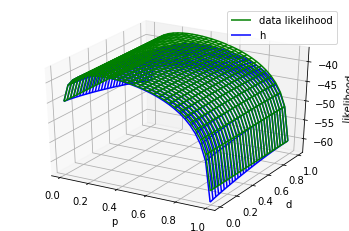

In [47]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot_wireframe(my_p, my_d, data_likelihood(my_p), 
                  color='green', label='data likelihood')
ax.plot_wireframe(my_p, my_d, expected_likelihood(my_p, my_d) + entropy(my_d), 
                  color='blue', label='h')

ax.set_xlabel('p')
ax.set_ylabel('d')
ax.set_zlabel('likelihood')
ax.legend()
plt.show()

In [48]:
def get_posterior_d(p):
    return q(N-1, 0, p)/(q(N-1, 0, p) + q(N-1, 1, p))

In [49]:
def get_mle_p(d):
    return n1(0, d) / N

In [53]:
p, d = 0.1, 0.9
for iter in range(10):
    print(f"iteration: {iter} p={p}, d={d}")
    op, od = p, d
    p = get_mle_p(d)
    d = get_posterior_d(p)
    if np.isclose(op, p) and np.isclose(od, d):
        break

iteration: 0 p=0.1, d=0.9
iteration: 1 p=0.39, d=0.11320665707885183
iteration: 2 p=0.3113206657078852, d=0.08278939988324406
iteration: 3 p=0.3082789399883244, d=0.08171557601338425
iteration: 4 p=0.3081715576013384, d=0.08167779351115557
iteration: 5 p=0.30816777935111556, d=0.08167646429047179


visualization of the first 2 iterations:

In [51]:
def plot_single_iteration(ax, p, d, e_or_m):
    
    if e_or_m == 'E':
        my_p = np.repeat(p, 30)
        my_d = np.linspace(0.01, 0.99, 30)
    else:
        my_d = np.repeat(d, 30)
        my_p = np.linspace(0.01, 0.99, 30)

    ax.scatter3D([p], [d], expected_likelihood(p, d) + entropy(d))
    ax.plot3D(my_p, my_d, data_likelihood(my_p), 
              color='green', label='data likelihood')
    ax.plot3D(my_p, my_d, expected_likelihood(my_p, my_d) + entropy(my_d), 
              color='blue', label='h')

    ax.set_xlim3d(0, 1)
    ax.set_ylim3d(0,1)
    ax.set_xlabel('p')
    ax.set_ylabel('d')
    ax.set_zlabel('likelihood')
    ax.legend()


iteration: 0 p=0.1, d=0.9


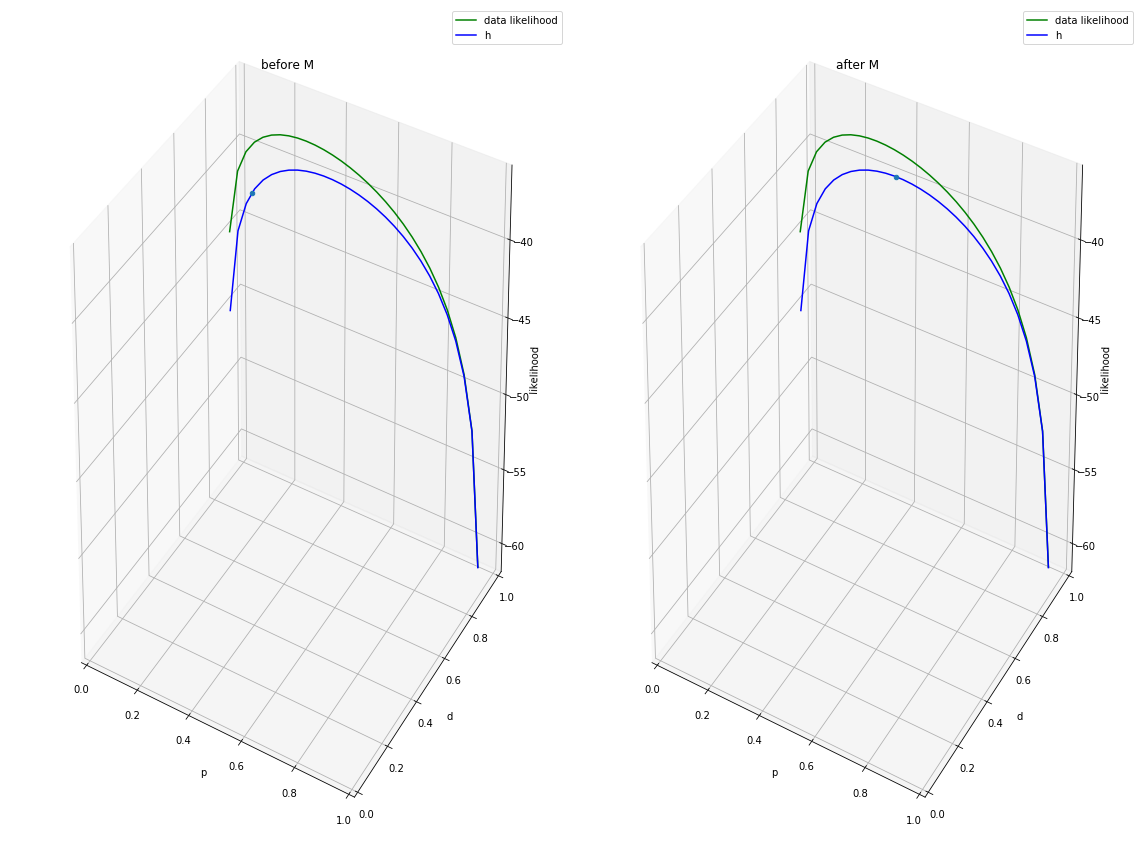

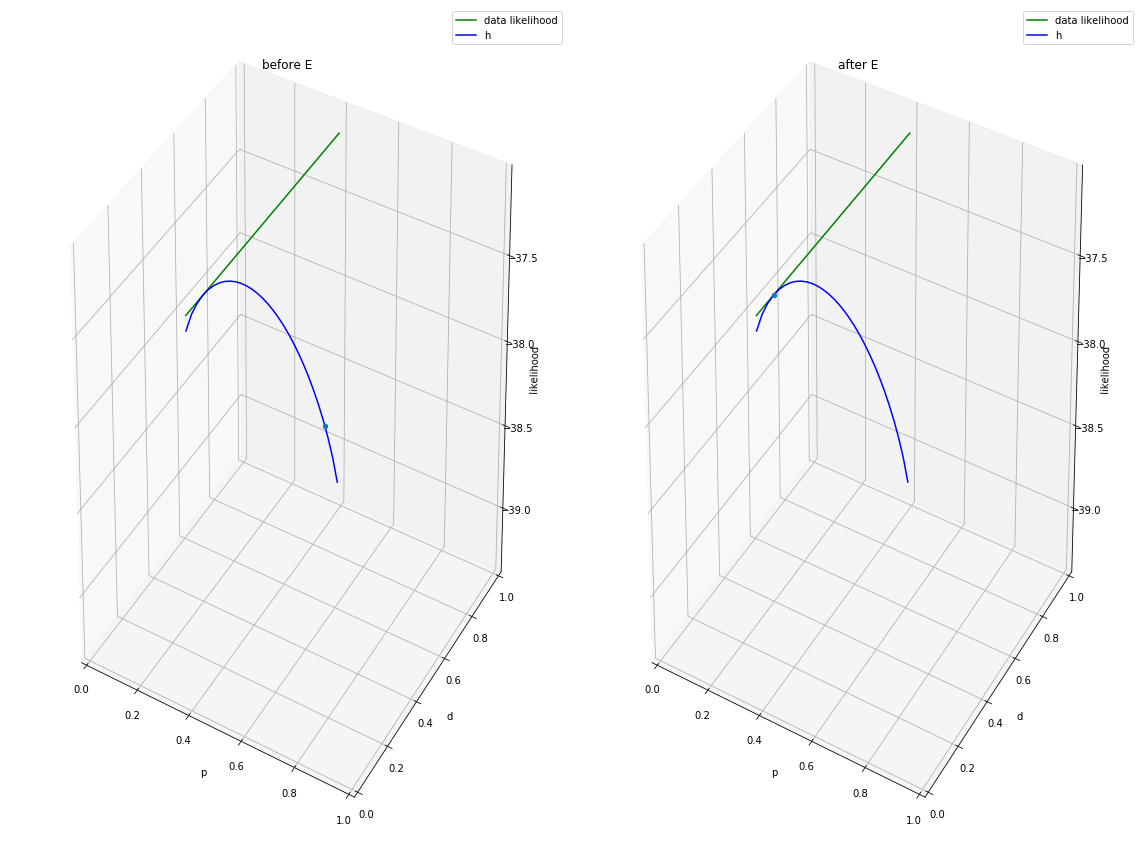

iteration: 1 p=0.39, d=0.11320665707885183


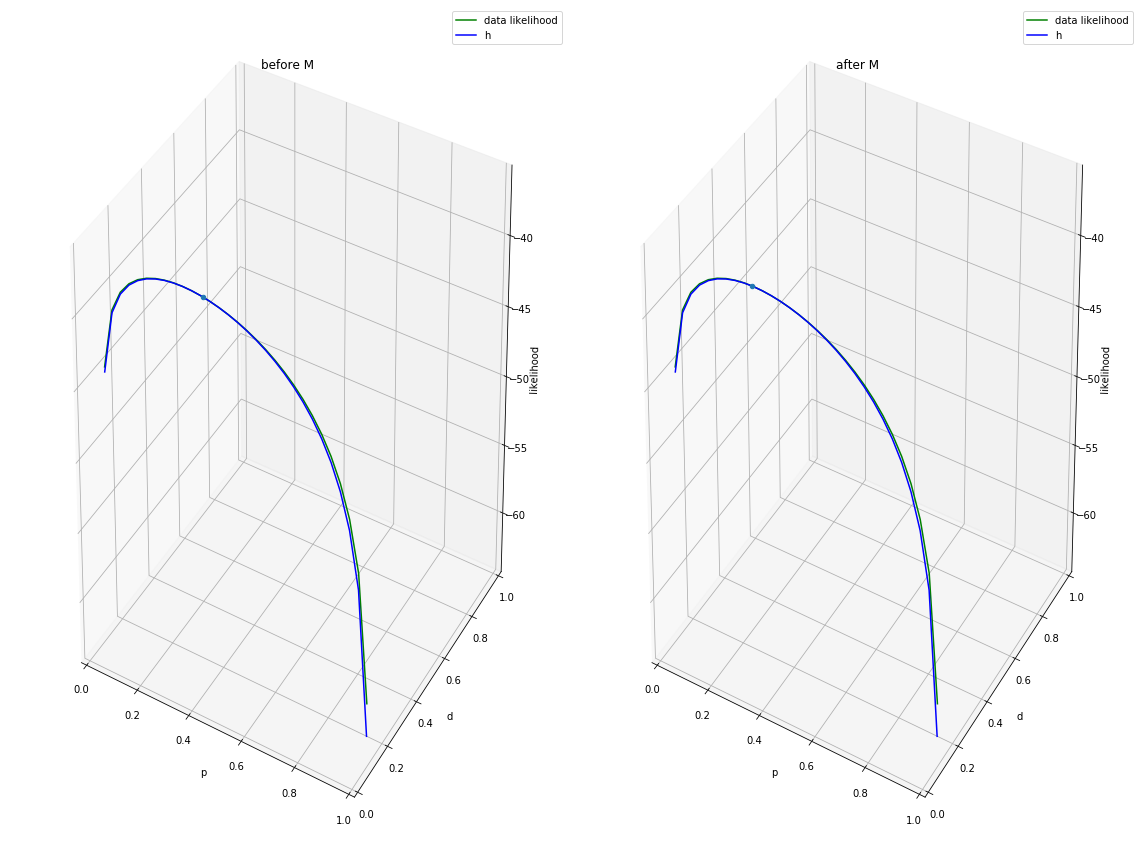

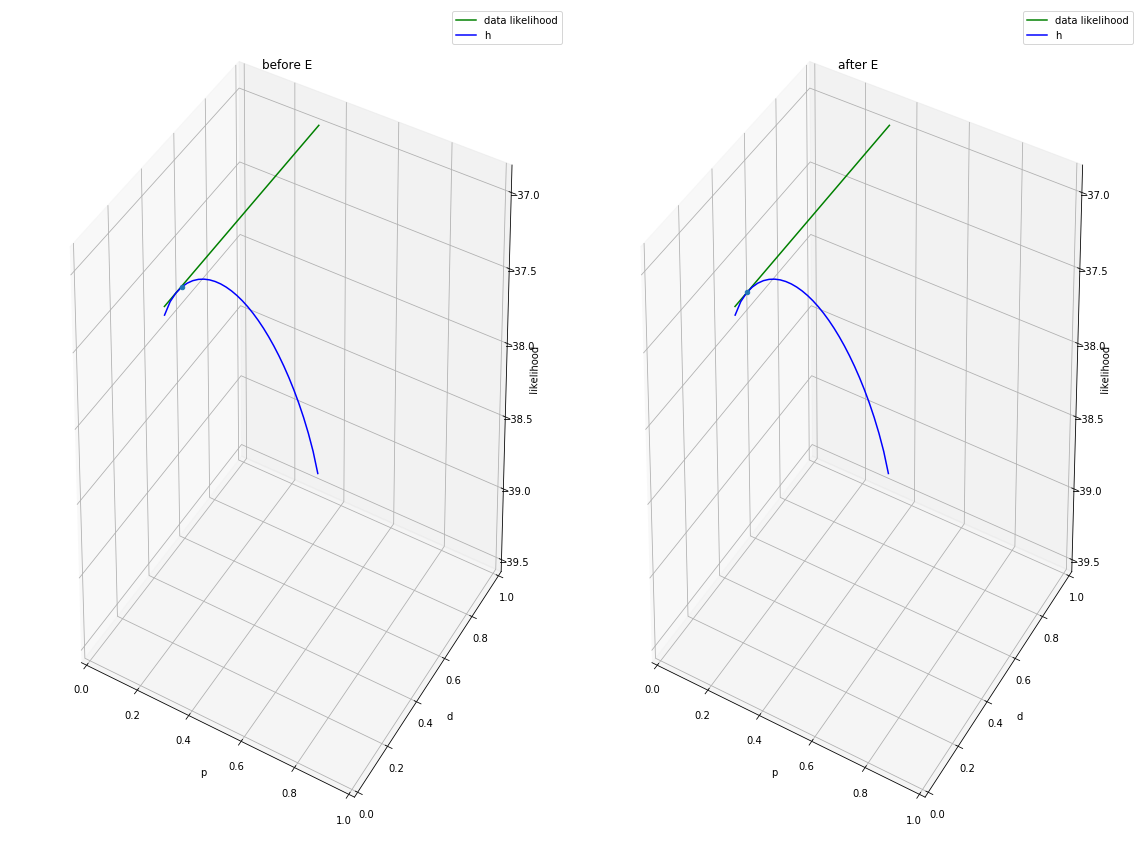

In [52]:
p, d = 0.1, 0.9

for iter in range(2):
    print(f"iteration: {iter} p={p}, d={d}")
    op, od = p, d
    def do_single_iteration(p, d, e_or_m):
        fig = plt.figure(figsize=(16, 12))
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        plot_single_iteration(ax, p, d, e_or_m)
        ax.set_title(f'before {e_or_m}')
        if e_or_m == 'M':
            p = get_mle_p(d)
        elif e_or_m == 'E':
            d = get_posterior_d(p)
        ax = fig.add_subplot(1, 2, 2, projection='3d')
        plot_single_iteration(ax, p, d, e_or_m)
        ax.set_title(f'after {e_or_m}')
        plt.tight_layout()
        plt.show()
        return p, d
    p, d = do_single_iteration(p, d, 'M')
    p, d = do_single_iteration(p, d, 'E')
    if np.isclose(op, p) and np.isclose(od, d):
        break